# News Aggregation Natural Language Processing

In this notebook, we'll be extending our understanding of sequence-based modeling by extracting sentiments and signals from real-world text data.

Specifically, we'll be applying LSTM networks against corpuses of news headlines from the year 2012 to 2018 obtained from HuffPost and attempting to extract sentiment from specific reviews - both ones pulled from the dataset for testing and ones we create ourselves!

#### 🔹 General Importations

In [1]:
# General Data Science Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Regular Expression Parsing and Word Cloud Mapping
import re, wordcloud

# Natural Language Toolkit
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download("stopwords")
nltk.download("wordnet")

# Language Token Processing and Frequency Distribution Calculator
from textblob import Word
from collections import Counter

# Generalized Machine/Deep Learning Codependencies
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow for Deep Learning
import tensorflow as tf

[nltk_data] Downloading package stopwords to /Users/Temp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Temp/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### 🔹 Deep Learning Functional Initializations

As good practice, let's initialize the specific tools we'll be using from `TensorFlow` to make things a little more readable moving forward.

In [2]:
# Stopwords: Generally Recognized Noisy Terms
STOPWORDS = nltk.corpus.stopwords

# Sequential Model Architecture
Sequential = tf.keras.models.Sequential

# Connective Layers with Dropout
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Early Stopping Optimization
EarlyStopping = tf.keras.callbacks.EarlyStopping

# Natural Text-Based Language Processing Layers with RNN
Embedding = tf.keras.layers.Embedding
LSTM = tf.keras.layers.LSTM
SpatialDropout1D = tf.keras.layers.SpatialDropout1D

# Language Tokenization Filter
Tokenizer = tf.keras.preprocessing.text.Tokenizer

# Padding Function for Dataset Ingestion Preprocessing
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

#### 🔹 Data Loading and Preprocessing

Let's first load and take a look at what data we're working with. 

In [3]:
CORPUS = "../dataset/News_Category_Dataset_v2.csv"

dataset = pd.read_csv(CORPUS, error_bad_lines=False)
# removing entries with null values
dataset = dataset.dropna()
dataset.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
# Taking out categories
df = dataset[dataset['category'].isin(['POLITICS','WELLNESS','ENTERTAINMENT','TRAVEL','STYLE & BEAUTY','PARENTING',
                        'HEALTHY LIVING','QUEER VOICES','FOOD & DRINK','BUSINESS','COMEDY','PARENTS','SPORTS'])]

# Making the catagories even
count = 0
df_classes = []

for category in df['category'].unique():
    
    df_class = df[df['category'] == category]
    
    df_class_under = df_class.sample(3445) # we equalize the catagories to have the same amount of entries
    df_classes.append(df_class_under)
    count+=1
    
short_df = pd.concat(df_classes, axis=0)
short_df = short_df.sort_index()
short_df.head()

,category,headline,authors,link,short_description,date
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
7,ENTERTAINMENT,What To Watch On Amazon Prime That’s New This ...,Todd Van Luling,https://www.huffingtonpost.com/entry/amazon-pr...,There's a great mini-series joining this week.,2018-05-26
10,ENTERTAINMENT,Justin Timberlake Visits Texas School Shooting...,Sebastian Murdock,https://www.huffingtonpost.com/entry/justin-ti...,"The pop star also wore a ""Santa Fe Strong"" shi...",2018-05-26
15,POLITICS,Edward Snowden: There's No One Trump Loves Mor...,Mary Papenfuss,https://www.huffingtonpost.com/entry/edward-sn...,"But don't count on Robert Mueller to nail him,...",2018-05-26


In [6]:
print("ORIGINAL DATA SET INFO")
print('------------------------------')
print(df['category'].nunique())
print('------------------------------')
print(df['category'].unique())
print('------------------------------')
print(df['category'].value_counts())

print('------------------------------')
print('------------------------------')
print('------------------------------')

print("UNDERSAMPLED DATA SET INFO")
print('------------------------------')
print(short_df['category'].nunique())
print('------------------------------')
print(short_df['category'].unique())
print('------------------------------')
print(short_df['category'].value_counts())

ORIGINAL DATA SET INFO
------------------------------
13
------------------------------
['ENTERTAINMENT' 'POLITICS' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'PARENTS' 'HEALTHY LIVING' 'WELLNESS' 'PARENTING'
 'STYLE & BEAUTY' 'FOOD & DRINK']
------------------------------
POLITICS          26913
WELLNESS          12827
ENTERTAINMENT     12192
TRAVEL             8011
STYLE & BEAUTY     7111
PARENTING          6408
HEALTHY LIVING     5072
QUEER VOICES       4669
FOOD & DRINK       4413
BUSINESS           4320
COMEDY             3709
PARENTS            3491
SPORTS             3445
Name: category, dtype: int64
------------------------------
------------------------------
------------------------------
UNDERSAMPLED DATA SET INFO
------------------------------
13
------------------------------
['ENTERTAINMENT' 'POLITICS' 'COMEDY' 'QUEER VOICES' 'SPORTS' 'BUSINESS'
 'TRAVEL' 'PARENTS' 'HEALTHY LIVING' 'WELLNESS' 'PARENTING'
 'STYLE & BEAUTY' 'FOOD & DRINK']
-----------------------

In [7]:
FEATURES_IMPUTED = ["headline", "category"]

processed = short_df[FEATURES_IMPUTED]
processed.isnull().sum()

headline    0
category    0
dtype: int64

---

#### 🔹 Language Processing for Data Ingestion

In [8]:
def clean_corpus(data, stopwords, dtype="frame", feature="verified_reviews"):
  """ Function to remove special characters, digits, stop words, 
  unimportant symbols, and other unnecessary noise from our dataset. """
  if dtype == "frame":
    data[feature] = data[feature].apply(
        lambda review: " ".join(review.lower() for review in review.split())
    )
    data[feature] = data[feature].str.replace(
        r"[^A-Za-z0-9 ]", r"",
        regex=True
    )
    data[feature] = data[feature].str.replace(
        "\d+", ""
    )
    data[feature] = data[feature].apply(
        lambda token: " ".join(token for token in token.split() if token not in stopwords)
    )
    data[feature] = data[feature].apply(
        lambda token: " ".join([Word(token).lemmatize() for token in token.split()])
    )
  elif dtype == "list":
    data = [" ".join(review.lower() for review in review.split()) for review in data]
    data = [re.sub(r"[^A-Za-z0-9 ]", r"", review) for review in data]
    data = [re.sub("\d+", "", review) for review in data]
    data = [" ".join(token for token in token.split() if token not in stopwords) for token in data]
    data = [" ".join([Word(token).lemmatize() for token in token.split()]) for token in data]
  return data

^^^^ TEXT ^^^^

In [9]:
stopwords = STOPWORDS.words("english")

processed = clean_corpus(data=processed, 
                         stopwords=stopwords,
                         dtype="frame",
                         feature="headline")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change fr

In [10]:
processed.head(5)

,headline,category
3,jim carrey blast castrato adam schiff democrat...,ENTERTAINMENT
4,julianna margulies us donald trump poop bag pi...,ENTERTAINMENT
7,watch amazon prime thats new week,ENTERTAINMENT
10,justin timberlake visit texas school shooting ...,ENTERTAINMENT
15,edward snowden there one trump love vladimir p...,POLITICS


^^^^ TEXT ^^^^

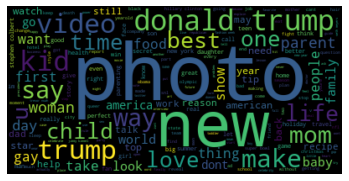

In [11]:
common_words = str()

for headline in processed["headline"]:
  headline = str(headline)
  tokens = headline.split()
  common_words += " ".join(tokens) + " "
frequencies = wordcloud.WordCloud().generate(common_words)
plt.imshow(frequencies, interpolation="bilinear")
plt.axis("off")
plt.show()

^^^^ TEXT ^^^^

In [12]:
label_encoder = LabelEncoder()
processed["category"] = label_encoder.fit_transform(
    processed["category"]
)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
processed.head(5)

,headline,category
3,jim carrey blast castrato adam schiff democrat...,2
4,julianna margulies us donald trump poop bag pi...,2
7,watch amazon prime thats new week,2
10,justin timberlake visit texas school shooting ...,2
15,edward snowden there one trump love vladimir p...,7


In [14]:
def tokenize_dataset(tokenizer, data):
  """ Function to tokenize input data for model training/testing. """
  return pad_sequences(tokenizer.texts_to_sequences(data))

In [15]:
tokenizer = Tokenizer(num_words=500, split=" ")
tokenizer.fit_on_texts(processed["headline"].values)

X = tokenize_dataset(tokenizer, processed["headline"].values)

In [16]:
X

array([[  0,   0,   0, ...,   0, 354,   3],
       [  0,   0,   0, ...,   7,   2, 273],
       [  0,   0,   0, ...,  69,   3,  33],
       ...,
       [  0,   0,   0, ...,  26, 160, 399],
       [  0,   0,   0, ...,   0, 366,  33],
       [  0,   0,   0, ...,   0, 263, 410]], dtype=int32)

In [17]:
y = pd.get_dummies(processed["category"])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=42)

---

#### 🔹 Data Ingestion and Predictive Modeling

In [19]:
# Embedding Layer for Token-Specific Vectorization
input_embedding_layer = Embedding(500, 120, input_length=X.shape[1])

# Dropout Regularizer for Text Embedding
embedding_dropout_layer = SpatialDropout1D(0.4)

# First Recurrent LSTM Cellular Architecture
first_recurrent_layer = LSTM(176, 
                             dropout=0.2, 
                             recurrent_dropout=0.2, 
                             return_sequences=True)

# Second Recurrent LSTM Cellular Architecture
second_recurrent_layer = LSTM(176, 
                              dropout=0.2, 
                              recurrent_dropout=0.2)

# Final Dense Layer for Output Extraction
output_connective_layer = Dense(13, activation="softmax")

2021-10-07 13:58:22.469749: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# Sequential Model Architecture Design
model = Sequential()

# Add All Initialized Layers in Effective Sequence
model.add(input_embedding_layer)
model.add(embedding_dropout_layer)
model.add(first_recurrent_layer)
model.add(second_recurrent_layer)
model.add(output_connective_layer)

# Get Model Summary for Confirmation
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 12, 120)           60000     
_________________________________________________________________
spatial_dropout1d (SpatialD  (None, 12, 120)           0         
ropout1D)                                                        
_________________________________________________________________
lstm (LSTM)                  (None, 12, 176)           209088    
_________________________________________________________________
lstm_1 (LSTM)                (None, 176)               248512    
_________________________________________________________________
dense (Dense)                (None, 13)                2301      
_________________________________________________________________
Total params: 519,901
Trainable params: 519,901
Non-trainable params: 0
__________________________________________________

In [21]:
# Compile Model with Specified Loss and Optimization Functions
model.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [22]:
# Define Early Stopping Callback Optimizer
callback = EarlyStopping(monitor="loss", patience=3)

# Define Batch Size and Epochs as Hyperparameters
batch_size, epochs = 32, 10

In [24]:
# Fit Learning Model Using Training Data and Configured Hyperparameters
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback],
                    verbose=True)

Epoch 1/10
980/980 [==============================] - 35s 36ms/step - loss: 1.6905 - accuracy: 0.4329
Epoch 2/10
980/980 [==============================] - 42s 43ms/step - loss: 1.6332 - accuracy: 0.4496
Epoch 3/10
980/980 [==============================] - 46s 47ms/step - loss: 1.6039 - accuracy: 0.4589
Epoch 4/10
980/980 [==============================] - 47s 48ms/step - loss: 1.5855 - accuracy: 0.4681
Epoch 5/10
980/980 [==============================] - 41s 42ms/step - loss: 1.5695 - accuracy: 0.4698
Epoch 6/10
980/980 [==============================] - 41s 42ms/step - loss: 1.5513 - accuracy: 0.4758
Epoch 7/10
980/980 [==============================] - 44s 45ms/step - loss: 1.5354 - accuracy: 0.4840
Epoch 8/10
980/980 [==============================] - 46s 47ms/step - loss: 1.5232 - accuracy: 0.4858
Epoch 9/10
980/980 [==============================] - 45s 46ms/step - loss: 1.5052 - accuracy: 0.4911
Epoch 10/10
980/980 [==============================] - 44s 45ms/step - loss: 1.490

In [25]:
# Evaluate Learned Model Using Testing Data
model.evaluate(X_test, y_test)

420/420 [==============================] - 3s 6ms/step - loss: 1.6060 - accuracy: 0.4745


[1.6059956550598145, 0.47454598546028137]

In [26]:
# Get Our Predicted Labels
y_pred = pd.DataFrame(data=model.predict(X_test), columns=[0,1,2,3,4,5,6,7,8,9,10,11,12])
y_pred = y_pred.apply(round, axis=1).astype(int)

In [27]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test.values.argmax(axis=1), 
                        y_pred=y_pred.values.argmax(axis=1))

In [72]:
def cmat_(cm, labels=None):
  """ Helper function to visualize confusion matrices. """
  ax = plt.subplot()
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  sns.heatmap(cm, annot=True, fmt="g", cmap="YlGnBu", linewidths=0.5, ax=ax)
  
  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")
  
  if labels.all():
      ax.set_xticklabels(labels)
      ax.set_yticklabels(labels)
    
  plt.show()

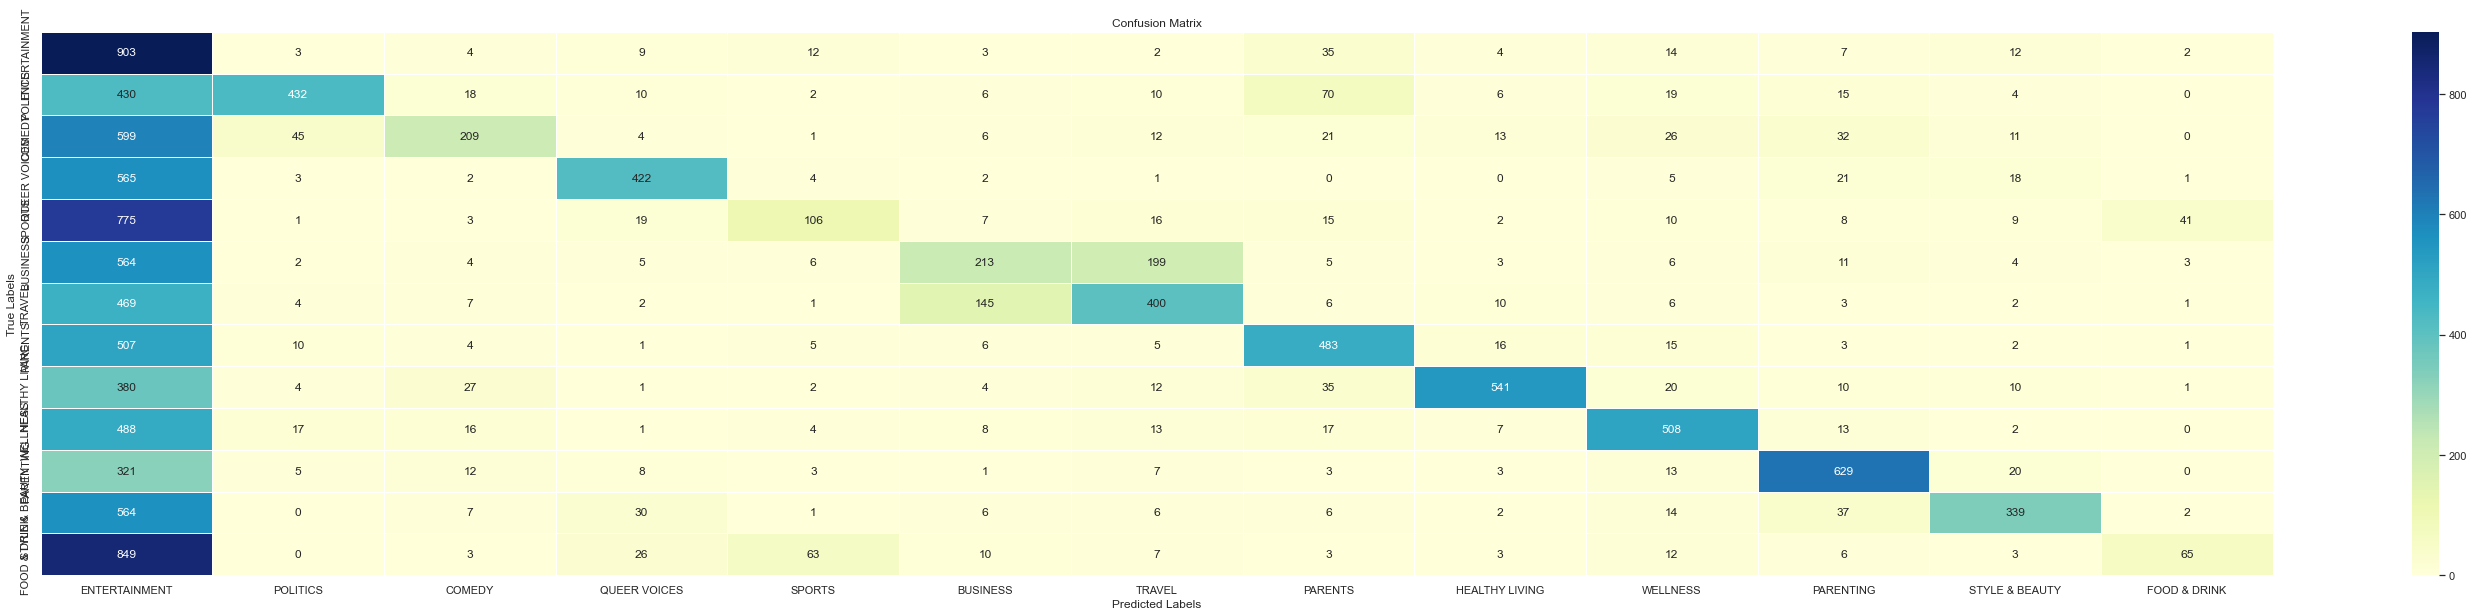

In [73]:
# Render Confusion Matrix as Seaborn Heatmap Visualization
cmat_(cmat, short_df['category'].unique())

In [35]:
# Create Classification Report with Summary Statistics/Metrics
print(classification_report(y_true=y_test.values.argmax(axis=1),
                            y_pred=y_pred.values.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.12      0.89      0.21      1010
           1       0.82      0.42      0.56      1022
           2       0.66      0.21      0.32       979
           3       0.78      0.40      0.53      1044
           4       0.50      0.10      0.17      1012
           5       0.51      0.21      0.30      1025
           6       0.58      0.38      0.46      1056
           7       0.69      0.46      0.55      1058
           8       0.89      0.52      0.65      1047
           9       0.76      0.46      0.58      1094
          10       0.79      0.61      0.69      1025
          11       0.78      0.33      0.47      1014
          12       0.56      0.06      0.11      1050

    accuracy                           0.39     13436
   macro avg       0.65      0.39      0.43     13436
weighted avg       0.65      0.39      0.43     13436

